# 第二章 端到端的机器学习项目（线性回归、决策树、随机森林）

## 准备工作

`Scikit-Learn`简介：

估算器：`fit()`

转换器：`transform()`

可以使用`fit_transfrom()`方法一步到位，但是`fit_transform()`输入需要一个二维数组，可以使用`reshape`函数转换。

预测器：`predict()`,返回一个包含相应预测的数据集，使用`score()`方法衡量测试集的预测质量。

所有估算器的超参数可以通过公共实例变量来访问（如：`imputer.strategy`），所有估算器的学习参数可以通过下划线后缀的公共实例变量来访问（如：`imputer.strategy_`）。

数据集被标识为`NumPy`数组或是`SciPy`稀疏矩阵。

任意序列的转换器最后加一个预测器就可以构成一个流水线。

`Scikit-Learn`为大多数参数设置了合理的默认值。

In [79]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import joblib

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")# , CHAPTER_ID

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 获取数据

In [2]:
import os
import tarfile
from six.moves import urllib

In [3]:
# 定义数据源及存储位置
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [4]:
# 定义获取数据的函数
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
# 获取数据
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

## 快速查看数据结构

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# 定义读取数据的函数
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
# 定义读取数据函数
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [9]:
housing = load_housing_data(HOUSING_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
# 使用value_counts()函数统计某一列的分类情况
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
#使用describe()函数显示数值属性的摘要
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


使用`describe()`函数显示数值属性的摘要
`count，mean，max，min`很清楚，但是不包括空值
`std`表示标准差：衡量数据的离散程度
25%，50%，75%表示百分位数：百分位数表示一组观测值中给定百分比的观测值都小于该值。如：`latitude`的25%为33.93，表示`latitude`中小于33.93的值有25%。
25%也称为百分之二十五分位数（第一四分位数）
50%也称为中位数
75%也称为百分之七十五分位数（第三四分位数）

Saving figure 数据各属性直方图


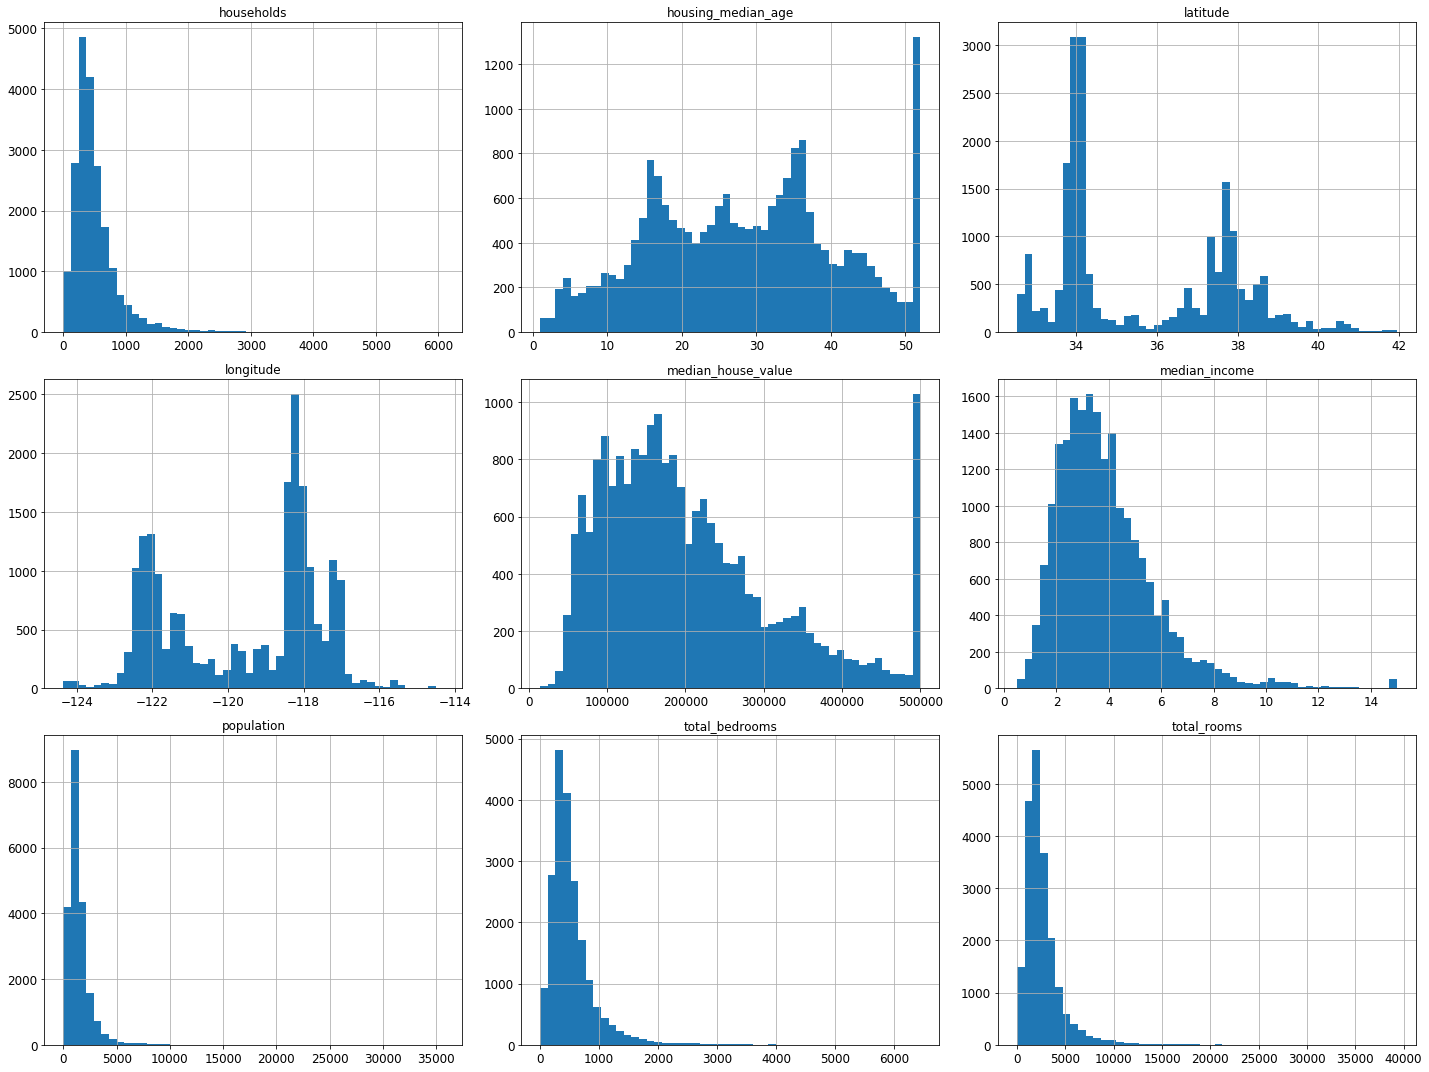

In [13]:
# 还可以通过直方图快速了解数据类型
# %matplotlib inline
housing.hist(bins=50, figsize=(20, 15))
save_fig("数据各属性直方图")# 先保存图再show()
plt.show()# 在jupyter中show方法调用可选

从图中看出，各个属性值被缩放的程度各不相同，房龄中位数和房价中位数的上限被限制了。
许多直方图表现出了重尾：在中位数右侧的延伸比在左侧的延伸远得多，后面会处理将它们转换为钟形（正态）。

## 创建测试集
暂时搁置创建测试集以避免出现窥探偏误

采用纯随机抽样会导致抽样偏差

采用分层抽样（分层次后按比例抽取）才能更好的选取更具代表性的样本，效果更好

分层抽样的要求：

保证每一层都有足够多的实例，也就是说，不应该把层数分的太多。

在预测房价平均值中，收入中位数是一个非常重要的属性，因此从收入中位数入手。

* 1、将收入中位数除以1.5（限制收入类别的数量）。

* 2、使用`ceil`函数取整。

* 3、最后将所有大于5的类别合并为类别5。

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

Saving figure 收入中位数的直方图


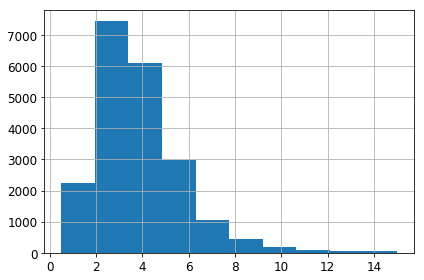

In [15]:
# 收入中位数的直方图，大部分在2-5
# %matplotlib inline
housing["median_income"].hist()
save_fig("收入中位数的直方图")
plt.show()

In [16]:
# 对收入中位数除以1.5，再取整，再将大于5的合并为类别5
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Saving figure 分类后的数据的比例分布直方图


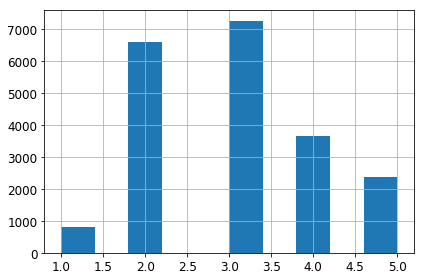

In [17]:
housing["income_cat"].hist()# 分类后的数据的直方图
housing["income_cat"].value_counts() / len(housing) # 分类后的数据的比例分布
save_fig("分类后的数据的比例分布直方图")

In [18]:
# 根据收入类别分层抽样
'''
random_state参数等同于np.random.seed,即：随机生成器种子，设置42是因为42是生命，宇宙，一切的答案
参数n_splits是将训练数据分成train/test对的组数，可根据需要进行设置，默认为10
'''
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]

In [19]:
# 测试集中数据比例分布
start_test_set["income_cat"].value_counts() / len(start_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [20]:
# 删除income_cat属性
for set in (start_train_set, start_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## 从数据探索和可视化中获得洞见

这一步不一定要非常彻底，关键是要迈出一步。

可以在原型中分析它的输出并再次回到探索的步骤

如果数据集非常大，可以抽样出一个探索集

本例中数据不是很多，可以直接操作。

In [21]:
# 先创建一个副本，从而操作不损害训练集。
housing = start_train_set.copy()

### 地理数据可视化

Saving figure 数据的地理分布图


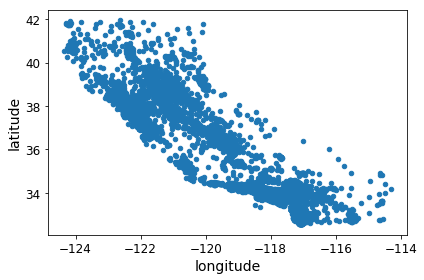

In [22]:
# longitude:经度
# latitude:维度
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("数据的地理分布图")

Saving figure 突出高密度区域的可视化


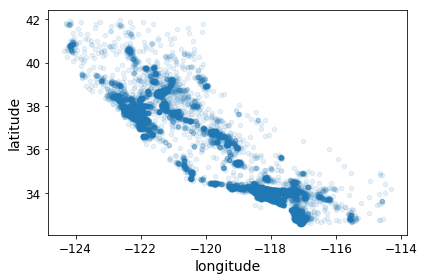

In [23]:
# 突出高密度区域的可视化，设置alpha为0.1
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("突出高密度区域的可视化")

Saving figure 加利福尼亚州房屋价格


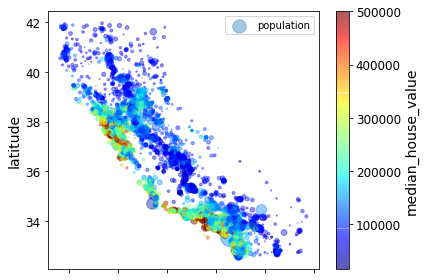

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
save_fig("加利福尼亚州房屋价格")

每个圆的半径大小代表了每个地区的人口数量，颜色代表价格，使用jet预定义的颜色表可视化显示，颜色从蓝（低）到红（高）

Saving figure california_housing_prices_plot


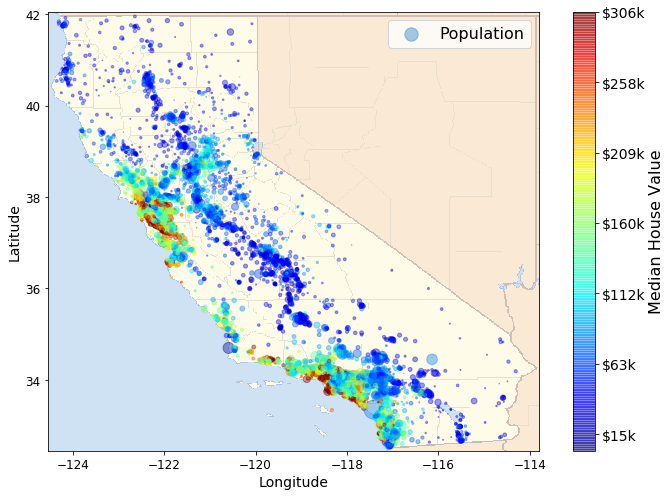

In [25]:
# 将地理图与真实地图结合绘制（代码重用）
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### 寻找相关性

In [26]:
# 计算每对属性的标准相关系数
corr_matrix = housing.corr()

In [27]:
# 查看每个属性与房屋中位数的相关性
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

相关系数从`-1`到`1`，越接近`1`，表明有越强的正相关；越接近`-1`，表明有越强的负相关；系数越靠近`0`表明二者之间没有线性相关性。

相关系数仅测量线性相关性，可能会忽略了非线性相关。

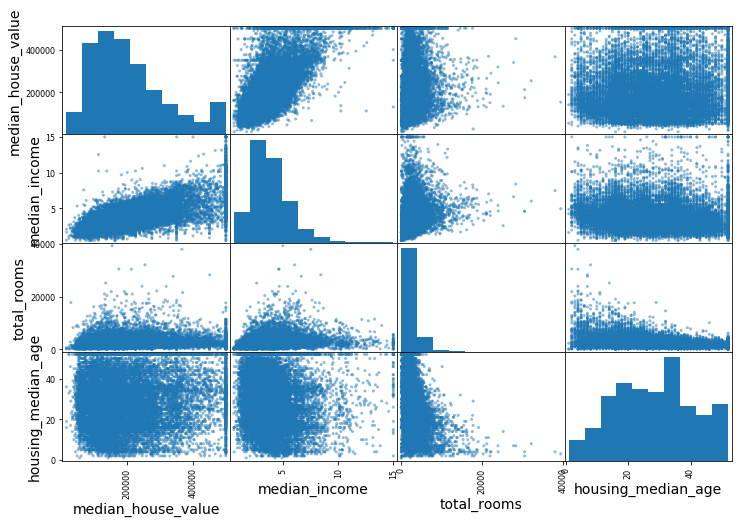

In [28]:
# 使用pandas中的scatter_matrix函数绘制出每个数值属性相对于其他数值属性的相关性
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Saving figure 收入中位数与房价中位数


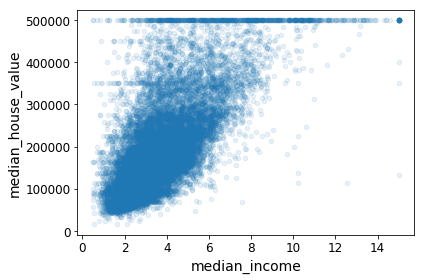

In [29]:
# 将与房价中位数最相关的收入中位数单独绘制
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
save_fig("收入中位数与房价中位数")

### 试验不同属性的组合

将一些似乎不是很有用，没有太大意义的属性进行组合，再考察相关性，可能会有新的发现。

In [30]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [31]:
# 查看相关性
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## 机器学习算法的数据准备

首先获得一个干净的训练集，并将预测器和标签分开

In [32]:
housing = start_train_set.drop("median_house_value", axis=1)
housing_labels = start_train_set["median_house_value"].copy()

### 数据清洗

`total_bedrooms`属性中有部分值缺失，可以用以下三种方法：

* 1、放弃这些空值数据

* 2、放弃这个属性

* 3、用某个值替代缺失值（0，平均数或者中位数）

可以使用`pandas`中的`dropna()`,`drop()`,`fillna()`函数实现

本例中使用`Scikit-Learn`中的`imputer`来处理缺失值：

In [33]:
# 创建一个imputer实例，指定要用属性的中位数来替代缺失值
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [34]:
# 由于中位数只能在数值属性上计算，因此将含有文本属性的列去掉
housing_num = housing.drop("ocean_proximity", axis=1)
# 使用fit函数将imputer实例适配到训练集
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [35]:
# imputer将计算的结果存储在“statistics_”中
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
# 为了稳妥，将imputer应用于所有的数值属性
X = imputer.transform(housing_num)
# 结果是一个Numpy数组，转换成DataFrame结果
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [37]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### 处理文本和分类属性

之前的`ocean_proximity`是一个文本属性列，无法计算他的中位数等。

可以使用`Scikit-Learn`的`LabelEncoder`来将文本属性学习后转换为数字。

但是转换后，在机器学习的过程中，算法可能会误判两个属性间的相似性。比如：`ocean_proximity`列中各属性转换的情况为`<1H OCEAN`, `INLAND`, `ISLAND`, `NEAR BAY`, `NEAR OCEAN``(0, 1, 2, 3, 4)`。机器学习算法可能会认为`<1H OCEAN`和`INLAND`两个属性更相似。实际是`<1H OCEAN`和`NEAR OCEAN`属性更相似。

因此，可以使用“独热编码”。比如，某行的`ocean_proximity`属性列值为`<1H OCEAN`，则在独热编码中该行的属性值为[1, 0, 0, 0, 0]。可以使用`Scikit-Learn`中的`OneHotEncoder`来转换。该函数经过计算后返回的是一个稀疏矩阵，并不是一个`NumPy`数组，稀疏矩阵的好处在于当数据量很大时，可以节省空间，并且只记录属性中非0项的位置。可以使用`toarray()`函数将稀疏矩阵转换成一个`NumPy`数组。

可以使用`Scikit-Learn`中的`LabelBinarizer`函数将文本转换成数字类别并转成独热编码，一步到位。该函数计算后返回的是一个`NumPy`数组。设置`LabelBinarizer`函数的`sparse_output=True`属性可以返回一个稀疏矩阵。

In [38]:
# 使用LabelBinarizer完成文本转换为数字类别再转换成独热编码
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
housing_cat = housing["ocean_proximity"]
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

要注意区分`LabelEncoder`,`OneHotEncoder`,`LabelBinarizer`三个方法。

在当前（2019年5月29日）的测试中，其中`Scikit-Learn`版本为0.21.1。发现`OneHotEncoder`与`LabelBinarizer`所能达到的效果一样。

### 自定义转换器

由于转换器并不是万能的，所以往往需要自定义转换器。

由于`Scikit-Learn`依赖于鸭子类型（`duck typing`）的编译，所以对象类型不由继承等方式决定，而由实际运行时所表现出的具体行为来决定。

在自定义转换器中，为了能和pipeline兼容使用，必须有`fit()`（返回自身）,`transform()`,`fit_transform()`三个方法。如果添加`TransformerMixin`作为基类，可以直接得到最后一个方法。如果添加`BaseEstimator`作为基类，可以获得两个非常有用的自动调整超参数的方法（`get_params()`和`set_params()`）

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [40]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


在本例中，设置了超参数`add_bedrooms_per_room`，且默认设置为`True`。通过设置超参数可以轻松知晓添加这个属性是否有助于机器学习的算法。

更广泛的说，当年对数据准备的步骤没有信心时，就可以添加超参数来把把关。同样，这些数据准备步骤越自动化，自动尝试的组合也就越多，从而更有可能找到一个重要的组合。

### 特征缩放

数据中的数值属性可能会有非常大的比例差异，可能会导致算法的性能表现不佳。但是目标值的数据往往不需要缩放。

可以使用最小-最大缩放或者标准化来同比例缩放所有属性。

最小-最大缩放（归一化），使用`Scikit-Learn`中的`MinMaxScaler`转换器实现。缩放的范围一般是0-1（神经网络的期望输入范围）。可以通过`feature_range`来修改缩放范围

标准化缩放的范围不是0-1，但标准化的方法受到异常值的影响较小。使用`Scikit-Learn`中的`StandardScaler`方法实现。

缩放器应该只用来拟合训练集，而不拟合测试集。

### 转换流水线

数据转换的步骤必须要以正确的顺序执行。`Scikit-Learn`提供`Pipeline`方法来支持这样的转换。

当需要把数值和文本类同时转换时，`Scikit-Learn`提供了`FeatureUnion`类。只需要提供一个转换器列表，就会自动调用`transform()`方法，并将它们连接起来。

每条子流水线从选择器转换器开始，只需挑出所需的属性（数值或分类），删除其余的数据，然后将生成的`DataFrame`转换为`NumPy`数组。但是`Scikit-Learn`没有提供用来处理`DataFrame`的方法。

In [41]:
# 编写函数实现`DataFrame`转换为`NumPy`
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [43]:
# 运行整条流水线
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## 选择和训练模型

至此，框出了问题，获得了数据，也进行了数据探索，对训练集和测试集进行了抽样并编写了转换流水线。现在是时候选择机器学习模型并展开训练了。

训练的模型应该妥善保存，还要同时保存超参数和训练过的参数，以及交叉验证的评分和实际预测的结果，可以使用`joblib`中的函数实现

In [74]:
# 定义一个绘制预测值与真实值结果的图像函数
def draw_compared(housing_predictions, housing_labels, name):
    plt.figure(figsize=(15,7))
    plt.plot(np.arange(len(housing_labels)), housing_labels, 'o', label='true value')
    plt.plot(np.arange(len(housing_predictions)), housing_predictions, '-', label='predict value')
    plt.legend()
    save_fig(name)
    plt.show()

In [80]:
# 定义一个保存模型的函数
def save_model(model, title):
    joblib.dump(model, title+".pkl")

In [81]:
# 定义一个读取模型的函数
def load_model(title):
    return joblib.load(title+".pkl")

In [77]:
# 定义一个输出验证集评分的函数
def display_scores(scores):
    print("Scores", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### 训练和评估模型

数据集说明：

`housing`:未压缩过的除去房价准确值的原训练集

`housing_prepared`:压缩过的训练集除去房价准确值的数据

`housing_labels`:训练集房价准确值

`X_test_prepared`:压缩过的测试集除去房价准确值的数据

`y_test`:测试集房价准确值

在压缩的过程中，会调用自定义转换器，并探索合适的属性组合

In [129]:
print(housing[:5])
print(housing_prepared[:5])
print(housing_labels[:5])
print()

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income ocean_proximity  
17606       710.0       339.0         2.7042       <1H OCEAN  
18632       306.0       113.0         6.4214       <1H OCEAN  
14650       936.0       462.0         2.8621      NEAR OCEAN  
3230       1460.0       353.0         1.8839          INLAND  
3555       4459.0      1463.0         3.0347       <1H OCEAN  
[[-1.15604281  0.77194962  0.74333089 -0.49323393 -0.44543821 -0.63621141
  -0.42069842 -0.61493744 -0.31205452 -0.08649871  0.15531753  1.
   0.  

先训练一个线性回归模型

In [69]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
# 保存模型
save_model(lin_reg, "线性回归模型")
# 读取模型
lin_reg = load_model("线性回归")

In [132]:
# 现在得到了一个模型，用几个训练集试试
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Saving figure 线性回归


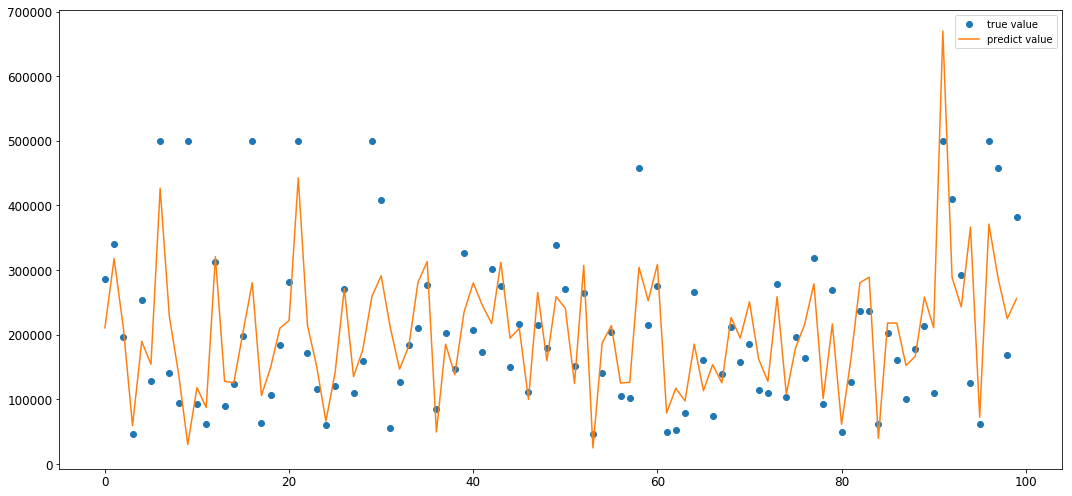

In [106]:
# 绘图
draw_compared(lin_reg.predict(housing_prepared[:100]), housing_labels[:100], "线性回归")

可以使用`Scikit-Learn`的`mean_squared_error`函数求均方误差

In [82]:
# 使用完整训练集的均方根误差评估模型
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

书上说法：由于大多数地区的`median_housing_values`分布在`120000`到`265000`美元之间，所以典型的预测误差达到68628美元只能算是差强人意。这就是一个典型的模型对训练数据拟合不足的案例。

个人理解：当在**训练集**上评估的时候误差**很大**就说明模型不好了，模型不好就可以看成是欠拟合。

图像表示：从图中更直接看出。

对于欠拟合，有三种主要的解决方法：

* 1、选择更强大的模型

* 2、为算法训练提供更好的特征的数据

* 3、减少对模型的限制

由于这不是一个正则化模型，可以排除使用第三种方法。

但现在，先尝试一个更复杂的模型。

使用`DecisionTreeRegressor`（决策树）模型训练。

In [84]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Saving figure 决策树


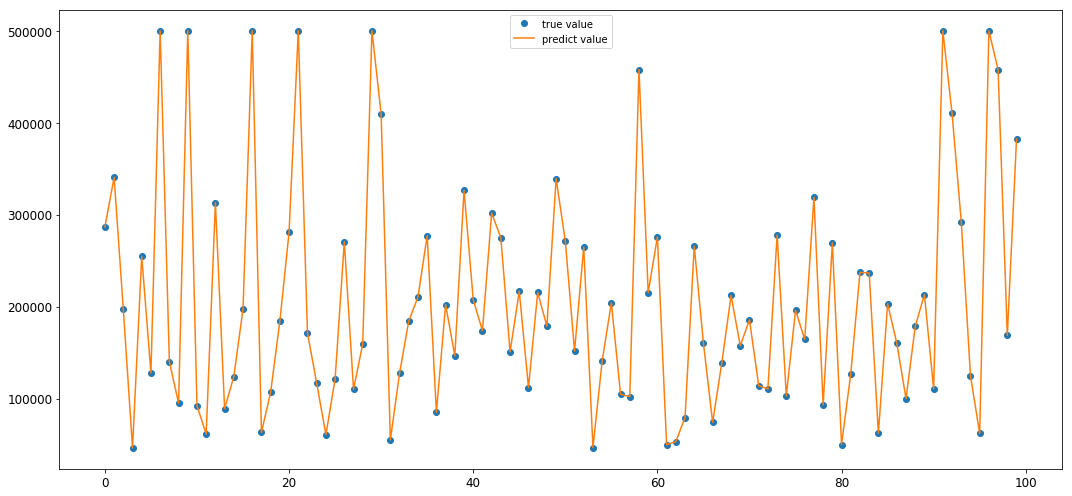

In [88]:
# 绘图
draw_compared(tree_reg.predict(housing_prepared[:100]), housing_labels[:100], "决策树")

使用训练集评估模型

In [89]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

用训练集评估模型，从评分上来看效果很好，但也可能是严重过拟合了（从图中可以明显看出过拟合）

### 使用交叉验证更好的进行评估

`Scikit-Learn`提供交叉验证功能，`cross_val_score`将训练集随机分割成`n`个不同的子集，每个子集称为一个折叠，然后对模型进行`n`次训练和评估，每次挑选1个折叠进行评估，使用另外的`n-1`个折叠训练。

In [93]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

`Scikit-Learn`的交叉验证功能更倾向于使用效用函数（越大越好）而不是成本函数（越小越好），所以计算分数的函数实际上是负的`MSE`（一个负值），所以上面的代码要加一个负号

In [94]:
# 使用上面的display_scores函数输出评分
display_scores(tree_rmse_scores)

Scores [67975.46400768 66792.95296227 72539.23415631 70515.78540438
 71491.94188505 74273.37235585 71791.74482988 70180.4946011
 74988.07544481 70966.62257003]
Mean: 71151.56882173479
Standard deviation: 2395.4606949601684


交叉验证不仅可以得到一个模型性能的评估值，还可以衡量该评估的精确度（即其标准偏差）。这里决策树得出的评分约为71200，上下浮动±3200。如果使用一个验证集，就不会得出这样的结果信息，因此交叉验证也需要多次训练模型才行。

In [95]:
# 也看一下线性回归模型的交叉验证评分
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


通过比较，发现决策树模型的确过拟合了，而且比线性回归模型还要糟糕。

接下来，再试试最后一个模型：`RandomForestRegressor`

随机森林模型通过对特征的随即子集进行许多个决策树的训练，然后对其预测取平均。在多个模型的基础之上建立模型，称为集成学习。

In [96]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

E:\Programme\Anaconda\envs\AIDS\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Saving figure 随机森林


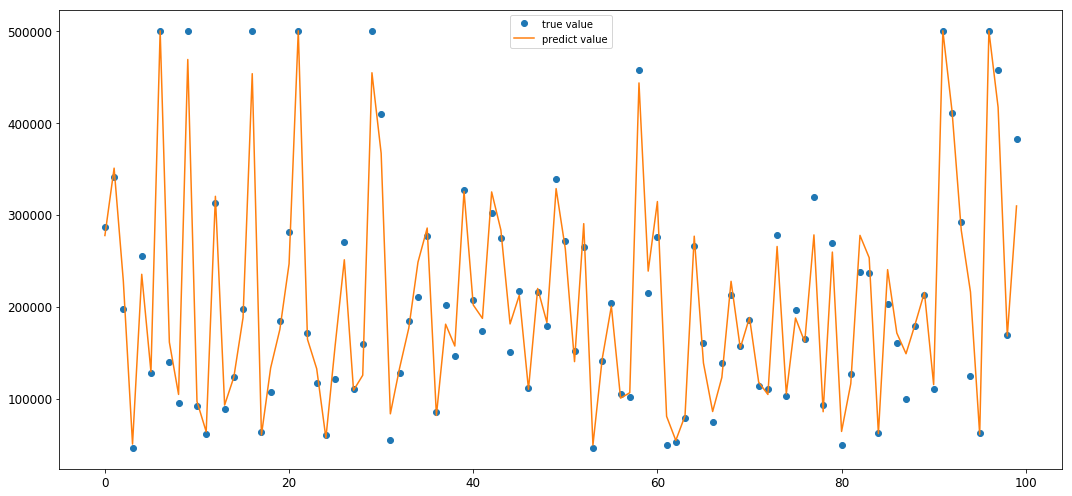

In [98]:
# 绘图
draw_compared(forest_reg.predict(housing_prepared[:100]), housing_labels[:100], "随机森林")

In [100]:
# 查看训练集评分
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22222.76292573825

In [101]:
# 查看交叉验证评分
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores [52940.79599766 50083.35479844 53160.70309788 55473.92226714
 53435.23796398 55382.78013622 51641.84518893 49938.98348281
 55988.01832775 53310.66002235]
Mean: 53135.63012831821
Standard deviation: 2014.4162664832152


从分数来看，随机森林效果好多了，但是，训练集分数远低于验证集分数，说明随机森林还是过拟合了。（从图中也可以看出）
解决过拟合有三种主要的方法：

* 1、简化模型

* 2、约束模型（使其正规化）

* 3、获得更多的训练数据

## 微调模型

### 网格搜索

一种微调的方法是手动调整超参数，找到一组很好的超参数值组合，需要耗费一定时间，且枯燥乏味。

但是`Scikit-Learn`提供了`GridSearchCV`方法来进行探索。所要做的只是告诉他你要进行实验的超参数是什么，以及需要尝试的值是什么。它将使用交叉验证来评估超参数值的所有可能组合。

当不知道超参数应该赋什么样的值的时候，一个简单的方法是连续尝试10的幂次方。

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50, 60, 70, 80, 90, 100], 'max_features': [2, 4, 6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 50, 60, 70, 80, 90, 100], 'max_features': [2, 3, 4, 6, 8, 10]},
  ]

forest_reg = RandomForestRegressor(random_state=42) 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8, 10]

上面的代码是搜索`RandomForestRegressor`的最佳组合。

`param_grid`告诉`Scikit-Learn`，首先评估第一个`dict`中的`n_estimator`和`max_feature`的所有`5×9=45`种超参数的组合。接着，尝试第二个`dict`中超参数值的所有`6×8=48`种超参数组合，但这次超参数`bootstrap`设置为`False`（`True`是该超参数的默认值）。

总之，网格搜索将探索`RandomForestRegressor`超参数值的`45+48=93`种超参数组合，并对每个模型进行`cv=5`（5-折）次交叉验证。所以，总共进行`93×5=465`次训练。

In [108]:
# 获得最佳的超参数组合
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 100}

In [112]:
# 获得更好的估算器
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

如果`GridSearchCV`被初始化为`refit=True`（同样也是默认值），那么一旦通过交叉验证找到了最佳估算器，他将在整个训练集上重新训练，这通常是个好方法，因为提供更多的数据很可能提升其性能。

In [114]:
# 当然也有评估分数
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
52522.07160182415 {'max_features': 2, 'n_estimators': 50}
52291.639566791055 {'max_features': 2, 'n_estimators': 60}
52235.4590892467 {'max_features': 2, 'n_estimators': 70}
52106.632810518626 {'max_features': 2, 'n_estimators': 80}
52011.99752320518 {'max_features': 2, 'n_estimators': 90}
52024.88690039341 {'max_features': 2, 'n_estimators': 100}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
49888.639694774 {'max_features': 4, 'n_estimators': 50}
49818.10914327986 {'max_features': 4, 'n_estimators': 60}
49846.21646188496 {'max_features': 4, 'n_estimators': 70}
49682.99044602979 {'max_features': 4, 'n_estimators': 80}
49602.15463836165 {'max_features': 4, 'n_estimators': 90}
49626.984207497

在本例中，我们找到了最佳的组合：`bootstrap:False, max_features:6, n_estimators:100`。该组合的`RMSE`分数为`48596`。因此，成功的找到了最佳组合。

在数据准备阶段，有些步骤也可以当做超参数来处理。例如，网格搜索会自动查找是否添加不确定的特征（比如是否使用转换器`CombinedAttributesAdder`的超参数`add_bedrooms_per_room`），同样，还可以用它来自动寻找处理问题的最佳方案，例如处理异常值，缺失特征，以及特征选择等。

### 随机搜索

当需要探索的超参数的搜索范围较大时，通常会优先选择使用`RandomizedSearchCV`。这个类用起来与`GridSearchCV`类大致相同，但他不会尝试所有可能的组合，而是在每次迭代中为每个超参数选择一个随机值，然后对一定数量的随机组合进行评估。这个方法有两个显著的特种：

* 1、如果允许随机搜索1000个迭代，那么将会探索每个超参数的1000个不同的值，而不是像网格搜索那样每个超参数仅探索少量几个值。

* 2、通过简单的设置迭代次数，可以更好地控制要分配给探索的超参数的计算预算。

### 集成方法

还有一种方法是将表现最优的模型组合起来。组合方法通常比最佳的单一模型更好，特别是当单一模型会产生严重不同类型的错误时更是如此。

## 分析最佳模型及其错误

通过检查最佳模型，你总是可以得到一些好的洞见。例如在进行准确评估时，`RandomForestRegressor`可以指出每个属性的相对重要程度。

In [117]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.06036700e-02, 7.31620944e-02, 4.19288171e-02, 1.68573854e-02,
       1.56256013e-02, 1.66236195e-02, 1.53293554e-02, 3.17191738e-01,
       5.65105222e-02, 1.06684277e-01, 8.94236357e-02, 8.36712010e-03,
       1.54237273e-01, 6.74920593e-05, 3.31268907e-03, 4.07470981e-03])

In [119]:
# 将这些重要性分数显示在对应的属性名称旁边
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31719173797004097, 'median_income'),
 (0.15423727268672927, 'INLAND'),
 (0.1066842771918908, 'pop_per_hhold'),
 (0.08942363568234891, 'bedrooms_per_room'),
 (0.08060367002226929, 'longitude'),
 (0.07316209444480642, 'latitude'),
 (0.056510522210549044, 'rooms_per_hhold'),
 (0.0419288171073262, 'housing_median_age'),
 (0.016857385412102424, 'total_rooms'),
 (0.016623619528482958, 'population'),
 (0.01562560127838431, 'total_bedrooms'),
 (0.015329355436279305, 'households'),
 (0.008367120098006886, '<1H OCEAN'),
 (0.004074709805315017, 'NEAR OCEAN'),
 (0.0033126890661827504, 'NEAR BAY'),
 (6.749205928539952e-05, 'ISLAND')]

还要查看一下系统产生的具体错误，尝试了解他们是怎么产生的，以及该如何解决（通过添加额外的特征，或是删除没有信息的特征，清楚异常值等）

### 通过测试集评估系统

通过一段时间的训练调参，终于有了一个表现不错的模型。现在用测试集评估最终模型。

这个过程没有什么特别的，只需要从测试集中获取预测器和标签，运行full_pipeline来转换数据（调用transform()而不是fit_transform()），然后在测试集上评估最终模型：

In [120]:
final_model = grid_search.best_estimator_

In [121]:
# 保存模型
save_model(final_model, "随机森林（调参后）")

In [124]:
X_test = start_test_set.drop("median_house_value", axis=1)
y_test = start_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

46287.46212003604

Saving figure 随机森林（调参后）


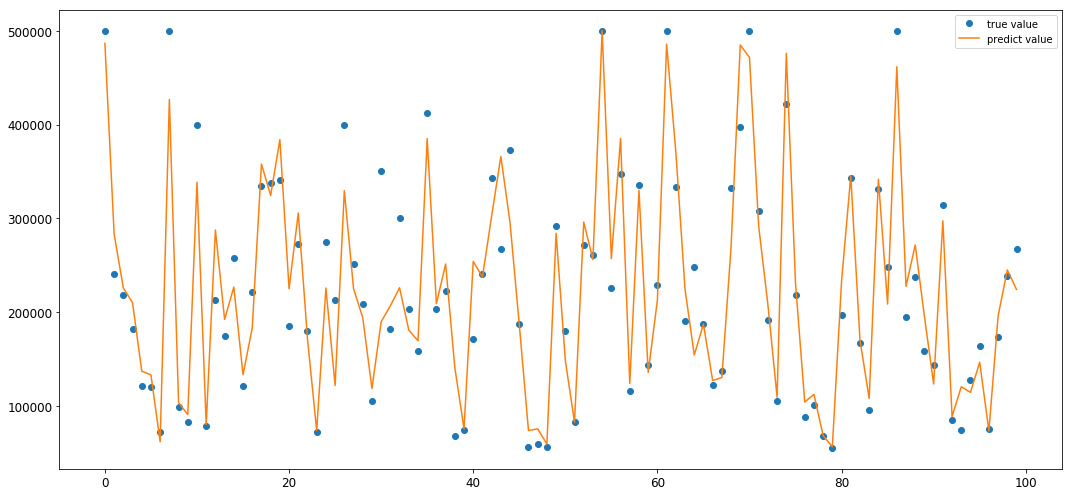

In [128]:
# 绘图（测试集图比较）
draw_compared(final_model.predict(X_test_prepared[:100]), y_test[:100], "随机森林（调参后）")

如果之前进行过大量的超参数调整，这使得评估结果通常会略逊于你之前使用交叉验证时的表现结果（因为通过不断调整，系统在验证数据上终于表现良好，在未知数据上可能达不到这么好的效果）。当这种情况发生时，一定要忍住继续调整超参数的诱惑。因为超参数调整的再好也只是在验证集上，泛化的时候达不到那么好的效果。

## 启动、监控和维护系统

当系统准备好后，接入生产数据源后，需要做以下工作：

* 1、需要编写监控代码，不仅需要捕捉系统的突然崩溃，在系统性能退化的时候也值得关注。这个问题很常见，因为随着时间的推移，数据不断进化，模型会逐渐“腐坏”，除非定期使用新数据训练模型。

* 2、需要对系统的预测结果进行抽样并评估，这一步通常需要人工分析。

* 3、需要评估输入系统的数据质量。质量较差的数据绘导致性能略微下降，但到触发警报还需要一段时间。所以如果监控系统的输入，就可以更快的捕捉到这个信号。对于在线学习来说，监控系统输入尤其重要。

* 4、一般来说，最后要使用新鲜数据定期训练你的模型，这个过程要尽可能自动化，如若不然，很可能最多每6个月需要定期更新一次你的模型，久而久之，系统性能会发生严重波动。如果是在线学习系统，应当定期保存系统状态的快速备份，以便于轻松回滚到之前的工作状态。

## 练习